In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lmfit
import numpy as np
from astropy.io import ascii
from astropy import units as u
from lmfit.models import PolynomialModel, GaussianModel
from lmfit import Model as mod
from lmfit import minimize, Parameters, report_fit
import scipy.integrate as integrate
import scipy.special as spec

In [2]:
# Open the file in read mode
with open('HISpectra/159.500-20.000_HI.txt', 'r') as file:
    # Read the content of the file
    content = file.read()
# Print the content
print(content)

%%  159.50000 -20.00000    0   0.20000
% LAB  survey ------------------
% wanted position:  l, b, RA, DEC, and interpolated  NH
%159.50 ; -20.00 ;  53.66 ;  31.05 ;  0.116E+22
% nearest position: l, b, RA, DEC, and observed NH
%159.50 ; -20.00 ;  53.66 ;  31.05 ;  0.116E+22
% GASS III survey --------------
% NH - median within 6 arcmin radius   0.00    
% NH - mean within specified beam      0.00    
% EBHIS survey -----------------
% NH  within specified beam           0.109E+22
%%EBHIS   621  datapoints: v_lsr [km/s] and T_B [K]
    -399.25     0.085
    -397.96     0.065
    -396.68     0.018
    -395.39    -0.065
    -394.10     0.073
    -392.81    -0.041
    -391.52    -0.043
    -390.23    -0.041
    -388.95     0.060
    -387.66     0.031
    -386.37    -0.058
    -385.08    -0.141
    -383.79    -0.068
    -382.50     0.012
    -381.22     0.031
    -379.93    -0.001
    -378.64     0.050
    -377.35     0.066
    -376.06     0.039
    -374.78     0.073
    -373.49    -0.013
 

In [3]:
len(content)

31397

In [4]:
file_path = 'HISpectra/159.500-20.000_HI.txt'
data = pd.read_csv(
    file_path,
    skiprows=12,
    sep='\s+',
    header=None,
    engine='python',
    on_bad_lines='skip',  # skip lines with wrong number of columns
    nrows=595
)
# Name the columns explicitly
data.columns = ['col1', 'col2']
# Extract x and y
x = data['col1']
y = data['col2'] / 10

print(data.head())

     col1   col2
0 -399.25  0.085
1 -397.96  0.065
2 -396.68  0.018
3 -395.39 -0.065
4 -394.10  0.073


In [5]:
# Load the file into a DataFrame
#df = pd.read_csv(file_path)  # Example: tab-delimited file
#df=pd.read_csv(file_path)
# Display the first few rows of the DataFrame
print(data)

       col1   col2
0   -399.25  0.085
1   -397.96  0.065
2   -396.68  0.018
3   -395.39 -0.065
4   -394.10  0.073
..      ...    ...
590  360.81 -0.006
591  362.09 -0.021
592  363.38 -0.013
593  364.67 -0.057
594  365.96 -0.165

[595 rows x 2 columns]


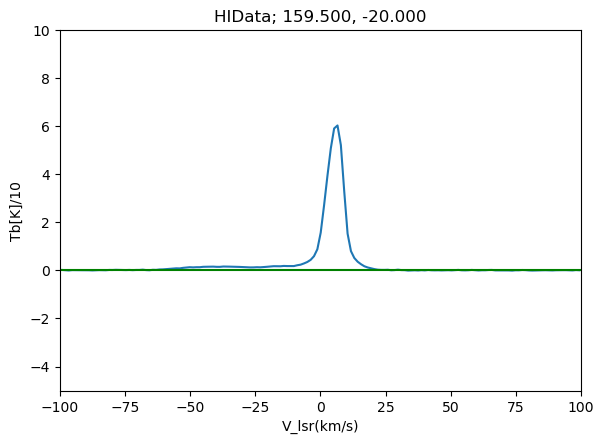

In [15]:
x = x.to_numpy()
y = y.to_numpy()
gooddata = (x >= -100) & (x <= 100)
x = x[gooddata]
y = y[gooddata]

plt.xlim([-100, 100])
plt.ylim([-5, 10])
plt.plot(x,y)
plt.axhline(0, color='green')
plt.xlabel('V_lsr(km/s)')
plt.ylabel('Tb[K]/10')
plt.title('HIData; 159.500, -20.000')
#plt.legend()
plt.tight_layout(pad=2.0) # so data doesn't overlap

In [16]:
# RMS red
noise=np.std(y) * u.K
noise

<Quantity 0.98985616 K>

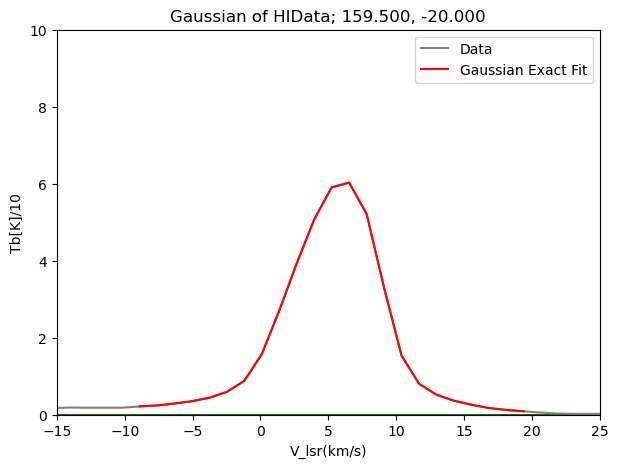

In [17]:
# Gaussian Model-exact fit
gauss_model=GaussianModel()
region = np.where((x >= -10) & (x <= 20))[0]

# Plot data
plt.figure(figsize=(7, 5))
plt.axhline(0, color='green')
plt.plot(x, y, label='Data', linestyle='solid', color='grey')
plt.xlim([-15, 25])
plt.ylim([0, 10])
plt.plot(x[region], y[region], '-',label='Gaussian Exact Fit',color='r')
plt.xlabel('V_lsr(km/s)')
plt.ylabel('Tb[K]/10')
plt.title('Gaussian of HIData; 159.500, -20.000')
plt.legend()
plt.show()

In [18]:
# Better fit of Gaussian
def gaussFit(vel, ta, bounds):
    '''
    Purpose:
    This function fits 4 features in a single spectrum, the features assumed to be the Local arm, inter arm, perseus arm, and outer arm.
    
    Input:
    vel -- x axes, velocity
    ta -- y axes, antenna temperature
    bounds -- an array of bounds for np.where commands later in the function to setup fit ranges.
    n = number of gaussian components

    Output:
    fitResult -- an array of 3 fit results from LMFIT for a single gaussian
    '''
    x=vel 
    y=ta
    # Set bounds:
    region = np.where((x >= bounds[0]) & (x <= bounds[1]))[0]
    # Initial Guess of the parameters
    params = gauss_model.guess(y[region], x=x[region])
    # Actual best fit to the data, given initial guess
    regionfit= gauss_model.fit(y[region], params, x=x[region])
    #fitresult = [region1fit, region2fit, region3fit]
    fitresult = [regionfit]
    return fitresult

In [19]:
fitResult = gaussFit(x, y, bounds = [-10, 20])

C:\Users\dhami\miniforge3\envs\STARTastro\Lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [20]:
fitResult[0].params

name,value,standard error,relative error,initial value,min,max,vary,expression
amplitude,49.2631927,1.20957148,(2.46%),57.39392399999999,-inf,inf,True,
center,5.58708274,0.09202709,(1.65%),5.898333333333333,-inf,inf,True,
sigma,3.24547018,0.09198900,(2.83%),3.2199999999999998,0.00000000,inf,True,
fwhm,7.64249808,0.21661753,(2.83%),7.5825204,-inf,inf,False,2.3548200*sigma
height,6.05556987,0.14856938,(2.45%),7.11082734366,-inf,inf,False,"0.3989423*amplitude/max(1e-15, sigma)"


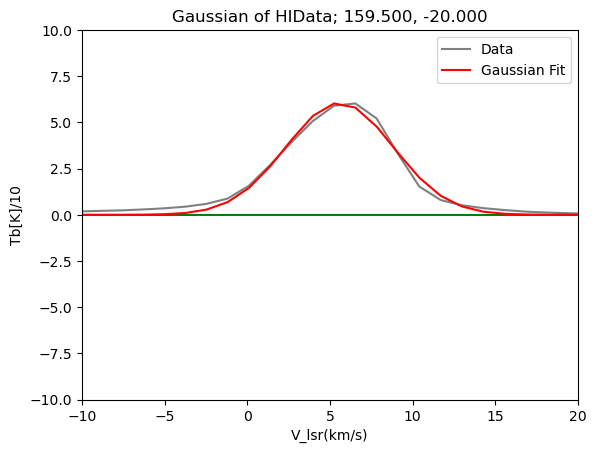

In [25]:
y_gauss_region = gauss_model.eval(fitResult[0].params, x=x)
# Plot data and baseline
plt.plot(x, y, label='Data', linestyle='solid', color='grey')
plt.axhline(0, color='green')
plt.xlim([-10, 20])
plt.ylim([-10, 10])
plt.plot(x, y_gauss_region, '-',label='Gaussian Fit',color='r')
plt.xlabel('V_lsr(km/s)')
plt.ylabel('Tb[K]/10')
plt.title('Gaussian of HIData; 159.500, -20.000')
plt.legend()
plt.show()